

 **🔧 ติดตั้งไลบรารีที่จำเป็น**



In [66]:
!pip install ultralytics
import ultralytics
print(ultralytics.__version__)
!pip install xmltodict

8.3.160




---




# **🔧 ติดตั้งไลบรารีที่จำเป็น**

In [67]:
import os
from google.colab import files
import shutil # Import the shutil module

# สร้างโฟลเดอร์ .kaggle ถ้ายังไม่มี
# นี่คือโฟลเดอร์ที่ Kaggle API จะมองหาไฟล์ kaggle.json
kaggle_dir = os.path.expanduser('~/.kaggle')
os.makedirs(kaggle_dir, exist_ok=True)

# อัปโหลดไฟล์ kaggle.json
print("Please upload your kaggle.json file:")
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    # ย้ายไฟล์ที่อัปโหลดไปยังโฟลเดอร์ .kaggle
    shutil.move(os.path.join('/content', fn), os.path.join(kaggle_dir, 'kaggle.json'))

# กำหนดสิทธิ์ให้ไฟล์ kaggle.json ปลอดภัย (อ่านและเขียนเฉพาะเจ้าของ)
!chmod 600 {os.path.join(kaggle_dir, 'kaggle.json')}

print("\nKaggle API Key uploaded and configured successfully!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 76 bytes

Kaggle API Key uploaded and configured successfully!


# **Data Preparation**

In [81]:
# prompt: Data Cleansing

import xmltodict
import pandas as pd
import re
import os # Ensure os is imported if used

def parse_annotation(annotation_path):
    with open(annotation_path, 'r', encoding='utf-8') as f:
        xml_content = f.read()
    try:
        annotation_dict = xmltodict.parse(xml_content)
        return annotation_dict
    except Exception as e:
        print(f"Error parsing {annotation_path}: {e}")
        return None

def get_object_details(annotation_dict):
    objects = []
    if annotation_dict and 'annotation' in annotation_dict and 'object' in annotation_dict['annotation']:
        # Ensure that 'object' is always treated as a list
        object_list = annotation_dict['annotation']['object']
        if not isinstance(object_list, list):
            object_list = [object_list]

        for obj in object_list:
            if 'name' in obj and 'bndbox' in obj:
                objects.append({
                    'name': obj['name'],
                    'xmin': int(obj['bndbox']['xmin']),
                    'ymin': int(obj['bndbox']['ymin']),
                    'xmax': int(obj['bndbox']['xmax']),
                    'ymax': int(obj['bndbox']['ymax'])
                })
    return objects

def validate_annotation(annotation_dict):
    if not annotation_dict or 'annotation' not in annotation_dict:
        return False, "Missing 'annotation' key"

    annotation_data = annotation_dict['annotation']

    if 'filename' not in annotation_data or not annotation_data['filename']:
        return False, "Missing or empty 'filename'"

    # Fix: Add 'in' to the 'height' check condition
    if 'size' not in annotation_data or 'width' not in annotation_data['size'] or 'height' not in annotation_data['size'] or 'depth' not in annotation_data['size']:
         return False, "Missing or incomplete 'size' information"

    if 'object' not in annotation_data:
        # Allow annotations with no objects but otherwise valid structure
        return True, "No objects found"

    # Ensure that 'object' is always treated as a list for validation
    object_list = annotation_data['object']
    if not isinstance(object_list, list):
        object_list = [object_list]

    for obj in object_list:
        if 'name' not in obj or not obj['name']:
            return False, "Missing or empty 'name' in object"
        if 'bndbox' not in obj or 'xmin' not in obj['bndbox'] or 'ymin' not in obj['bndbox'] or 'xmax' not in obj['bndbox'] or 'ymax' not in obj['bndbox']:
            return False, "Missing or incomplete 'bndbox' in object"

        try:
            xmin, ymin, xmax, ymax = int(obj['bndbox']['xmin']), int(obj['bndbox']['ymin']), int(obj['bndbox']['xmax']), int(obj['bndbox']['ymax'])
            if xmin < 0 or ymin < 0 or xmax <= xmin or ymax <= ymin:
                 return False, f"Invalid bounding box coordinates for object '{obj.get('name', 'Unknown')}': ({xmin}, {ymin}, {xmax}, {ymax})"
        except (ValueError, TypeError):
             return False, f"Non-integer bounding box coordinates for object '{obj.get('name', 'Unknown')}'"

    return True, "Valid"

# Example usage (assuming annotation files are in a directory 'annotations')
# This code assumes a directory named 'annotations' exists containing the XML files.
# Based on previous steps, your XMLs are likely in '/content/fruit_dataset/all_images'
annotation_dir = '/content/fruit_dataset/all_images' # Update this path to where your XMLs are
invalid_annotations = []
valid_annotations_data = []

if os.path.exists(annotation_dir):
    for filename in os.listdir(annotation_dir):
        if filename.endswith('.xml'):
            annotation_path = os.path.join(annotation_dir, filename)
            annotation_dict = parse_annotation(annotation_path)
            is_valid, reason = validate_annotation(annotation_dict)
            if not is_valid:
                invalid_annotations.append({'filename': filename, 'reason': reason})
                # Optionally delete or quarantine invalid files
                # os.remove(annotation_path)
                # print(f"Deleted invalid annotation: {filename}")
            else:
                # Process valid annotations, e.g., extract object details
                valid_annotations_data.append({
                    'filename': annotation_dict['annotation']['filename'],
                    'objects': get_object_details(annotation_dict)
                })
                # print(f"Annotation {filename} is valid.") # Indicate which files are kept - uncomment if needed

    print("\n--- Data Cleansing Summary ---")
    print(f"Total XML files found: {len([f for f in os.listdir(annotation_dir) if f.endswith('.xml')])}")
    print(f"Number of invalid annotations found: {len(invalid_annotations)}")
    if invalid_annotations:
        print("Details of invalid annotations:")
        for item in invalid_annotations:
            print(f"- {item['filename']}: {item['reason']}")

    # You can now work with valid_annotations_data
    # For example, create a DataFrame or further process the data
    # print("\nValid annotations data sample:")
    # print(valid_annotations_data[:5]) # Print first 5 valid annotation summaries

else:
    print(f"Annotation directory '{annotation_dir}' not found.")

# Optional: Create a DataFrame of valid annotations for further analysis
# if valid_annotations_data:
#     # Flatten the structure if needed for DataFrame, e.g., one row per object
#     flattened_data = []
#     for ann in valid_annotations_data:
#         img_filename = ann['filename']
#         if not ann['objects']: # Handle images with no objects
#              flattened_data.append({'image_filename': img_filename, 'object_name': None, 'xmin': None, 'ymin': None, 'xmax': None, 'ymax': None})
#         else:
#             for obj in ann['objects']:
#                 flattened_data.append({
#                     'image_filename': img_filename,
#                     'object_name': obj['name'],
#                     'xmin': obj['xmin'],
#                     'ymin': obj['ymin'],
#                     'xmax': obj['xmax'],
#                     'ymax': obj['ymax']
#                 })
#     df_valid_annotations = pd.DataFrame(flattened_data)
#     print("\nDataFrame of valid annotations (first 5 rows):")
#     print(df_valid_annotations.head())


--- Data Cleansing Summary ---
Total XML files found: 300
Number of invalid annotations found: 0


In [68]:
import os
import zipfile
import shutil
from tqdm.notebook import tqdm

kaggle_owner = "mbkinaci"
kaggle_dataset_slug = "fruit-images-for-object-detection"
dataset_full_name = f"{kaggle_owner}/{kaggle_dataset_slug}"

destination_folder = "/content/fruit_dataset"

# สร้างโฟลเดอร์ปลายทางถ้ายังไม่มี
os.makedirs(destination_folder, exist_ok=True)

print(f"Downloading dataset: {dataset_full_name} to {destination_folder} using Kaggle CLI...")

try:

    !kaggle datasets download -d {dataset_full_name} -p {destination_folder} --unzip

    print(f"Dataset '{dataset_full_name}' downloaded and unzipped to: {destination_folder}")

    zip_files_in_dest = [f for f in os.listdir(destination_folder) if f.endswith('.zip')]

    if zip_files_in_dest:
        print("\nFound zip files in destination folder, extracting them...")
        for zip_file in tqdm(zip_files_in_dest, desc="Extracting remaining zip files"):
            zip_path = os.path.join(destination_folder, zip_file)
            # แตกไฟล์ไปที่ subfolder เดียวกัน
            extract_folder = os.path.join(destination_folder, os.path.splitext(zip_file)[0])
            os.makedirs(extract_folder, exist_ok=True) # ตรวจสอบให้แน่ใจว่าโฟลเดอร์ปลายทางมีอยู่
            print(f"Extracting {zip_file} to {extract_folder}...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_folder)
            print(f"Extracted {zip_file}.")
            # ลบไฟล์ zip หลังจากแตกไฟล์แล้วเพื่อประหยัดพื้นที่
            os.remove(zip_path)
    else:
        print("No further zip files found in destination folder to extract.")

except Exception as e:
    print(f"An error occurred during dataset download or extraction: {e}")
    print("Please ensure your kaggle.json is correctly uploaded and configured.")
    print("Also, check the exact name of the dataset 'mbkinaci/fruit-images-for-object-detection' on Kaggle.")


print("\nDataset structure after extraction:")
# แสดงโครงสร้างของโฟลเดอร์หลัก 2-3 ระดับแรก
!ls -R {destination_folder} | head -n 30

Dataset URL: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection
License(s): CC0-1.0
 71% 20.0M/28.4M [00:00<00:00, 208MB/s]
100% 28.4M/28.4M [00:00<00:00, 171MB/s]
Dataset 'mbkinaci/fruit-images-for-object-detection' downloaded and unzipped to: /content/fruit_dataset
No further zip files found in destination folder to extract.

Dataset structure after extraction:
/content/fruit_dataset:
all_images
test_zip
train_zip

/content/fruit_dataset/all_images:
apple_10.jpg
apple_10.xml
apple_11.jpg
apple_11.xml
apple_12.jpg
apple_12.xml
apple_13.jpg
apple_13.xml
apple_14.jpg
apple_14.xml
apple_15.jpg
apple_15.xml
apple_16.jpg
apple_16.xml
apple_17.jpg
apple_17.xml
apple_18.jpg
apple_18.xml
apple_19.jpg
apple_19.xml
apple_1.jpg
apple_1.xml
apple_20.jpg
apple_20.xml


# **Train/Test Split**

In [69]:
import os
import shutil
import xml.etree.ElementTree as ET
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# กำหนดพารามิเตอร์
split_ratio = 0.8  # 80% สำหรับ train, 20% สำหรับ test

# Path ต้นทาง
dataset_path = "/content/fruit_dataset/all_images"  # รวมภาพและ .xml ไว้ด้วยกัน

# Path ปลายทาง YOLO format
yolo_data_path = "/content/yolo_dataset"
yolo_images_train_path = os.path.join(yolo_data_path, "images", "train")
yolo_labels_train_path = os.path.join(yolo_data_path, "labels", "train")
yolo_images_test_path = os.path.join(yolo_data_path, "images", "test")
yolo_labels_test_path = os.path.join(yolo_data_path, "labels", "test")

# สร้างโฟลเดอร์ปลายทาง
os.makedirs(yolo_images_train_path, exist_ok=True)
os.makedirs(yolo_labels_train_path, exist_ok=True)
os.makedirs(yolo_images_test_path, exist_ok=True)
os.makedirs(yolo_labels_test_path, exist_ok=True)

# กำหนดคลาสของวัตถุ
class_names = ["apple", "banana", "orange"]

def convert_xml_to_yolo(xml_file_path, image_width, image_height):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    yolo_annotations = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        if name not in class_names:
            print(f"Warning: Unknown class '{name}' in {xml_file_path}")
            continue
        class_id = class_names.index(name)
        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        center_x = (xmin + xmax) / 2 / image_width
        center_y = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height

        yolo_annotations.append(f"{class_id} {center_x} {center_y} {width} {height}")
    return yolo_annotations

def process_split(image_list, image_target_dir, label_target_dir):
    for image_file in tqdm(image_list):
        base_name = os.path.splitext(image_file)[0]
        xml_file = base_name + ".xml"
        xml_path = os.path.join(dataset_path, xml_file)
        img_path = os.path.join(dataset_path, image_file)

        if not os.path.exists(xml_path):
            print(f"Warning: XML missing for {image_file}")
            continue

        try:
            with Image.open(img_path) as img:
                w, h = img.size
        except Exception as e:
            print(f"Error reading image size: {image_file} - {e}")
            continue

        annotations = convert_xml_to_yolo(xml_path, w, h)

        # Copy image
        shutil.copy(img_path, os.path.join(image_target_dir, image_file))

        # Write label
        label_path = os.path.join(label_target_dir, base_name + ".txt")
        with open(label_path, "w") as f:
            for line in annotations:
                f.write(line + "\n")

# รายชื่อไฟล์ภาพ
all_images = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# แบ่ง train/test
train_files, test_files = train_test_split(all_images, train_size=split_ratio, random_state=42)

print(f"Total images: {len(all_images)} | Train: {len(train_files)} | Test: {len(test_files)}")

# ประมวลผล
process_split(train_files, yolo_images_train_path, yolo_labels_train_path)
process_split(test_files, yolo_images_test_path, yolo_labels_test_path)

print("\n✅ Split & conversion complete.")
print(f"Train images: {len(os.listdir(yolo_images_train_path))}")
print(f"Test images: {len(os.listdir(yolo_images_test_path))}")


Total images: 300 | Train: 240 | Test: 60


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]


✅ Split & conversion complete.
Train images: 290
Test images: 110


In [70]:
import yaml
import os

# Path ไปยังโฟลเดอร์ dataset ที่เตรียมไว้
yolo_data_path = "/content/yolo_dataset"

# กำหนดคลาสของวัตถุ (ต้องตรงกับ class_names ที่แก้ไขในขั้นตอนที่ 2)
# !!! ตรวจสอบว่าตรงกับที่คุณแก้ไขไปในขั้นตอนที่ 2 แล้ว
class_names = ["apple", "banana", "orange"]

data_yaml = {
    'path': yolo_data_path,  # Root path ของ dataset
    'train': 'images/train', # Path ไปยังโฟลเดอร์รูปภาพ train (สัมพันธ์กับ 'path')
    'val': 'images/test',    # Path ไปยังโฟลเดอร์รูปภาพ validation/test (สัมพันธ์กับ 'path')
    'names': {i: name for i, name in enumerate(class_names)}, # Mapping class ID to class name
    'nc': len(class_names)   # จำนวนคลาส
}

# บันทึกไฟล์ YAML
yaml_path = os.path.join(yolo_data_path, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

print(f"Dataset YAML file created at: {yaml_path}")
print("Content of data.yaml:")
!cat {yaml_path}

Dataset YAML file created at: /content/yolo_dataset/data.yaml
Content of data.yaml:
names:
  0: apple
  1: banana
  2: orange
nc: 3
path: /content/yolo_dataset
train: images/train
val: images/test




# **> การฝึกโมเดล (Model Training)**



In [71]:
from ultralytics import YOLO
import os

# โหลดโมเดล YOLOv8 ที่ train มาแล้ว (pre-trained weights)
# เราจะใช้โมเดล 'yolov8n.pt' (n คือ nano model ซึ่งเล็กและเร็ว เหมาะสำหรับเริ่มต้น)
# คุณสามารถลองโมเดลที่ใหญ่ขึ้นได้ เช่น 'yolov8s.pt' (small), 'yolov8m.pt' (medium)
model = YOLO('yolov8n.pt')

# กำหนด Path ไปยังไฟล์ YAML ของ dataset
yaml_data_path = "/content/yolo_dataset/data.yaml"

# เริ่มกระบวนการ Train!
# epochs: จำนวนรอบของการฝึก (ยิ่งมากยิ่งเรียนรู้ได้ดีขึ้น แต่ระวัง overfitting)
# imgsz: ขนาดของภาพที่ใช้ในการ train (ควรปรับตามขนาดภาพใน dataset)
# batch: จำนวนภาพที่ประมวลผลในแต่ละครั้ง (ยิ่งมากยิ่งใช้ GPU memory มาก)
# name: ชื่อของ run (ผลลัพธ์จะถูกบันทึกใน runs/detect/name)
# device: '0' หมายถึงใช้ GPU ตัวแรก ถ้าไม่มี GPU ใช้ 'cpu'
results = model.train(
    data=yaml_data_path,
    epochs=30, # เริ่มด้วย 100 epochs เพื่อให้โมเดลมีโอกาสเรียนรู้มากขึ้น
    imgsz=640, # ขนาดภาพที่ใช้ในการ train
    batch=16,  # Batch size
    name='fruit_detection_yolov8n',
    device=0   # ใช้ GPU
)

print("\nTraining complete! Results saved in runs/detect/fruit_detection_yolov8n")

Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fruit_detection_yolov8n3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

train: Scanning /content/yolo_dataset/labels/train... 290 images, 0 backgrounds, 0 corrupt: 100%|██████████| 290/290 [00:00<00:00, 1549.90it/s]

train: New cache created: /content/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 522.9±357.1 MB/s, size: 114.1 KB)


val: Scanning /content/yolo_dataset/labels/test... 110 images, 0 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<00:00, 536.58it/s]

val: /content/yolo_dataset/images/test/apple_62.jpg: corrupt JPEG restored and saved
val: New cache created: /content/yolo_dataset/labels/test.cache


Plotting labels to runs/detect/fruit_detection_yolov8n3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/fruit_detection_yolov8n3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.09G      1.143      2.826      1.501         16        640: 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

                   all        110        226    0.00653      0.953      0.479      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.4G      1.181      2.075      1.506          3        640: 100%|██████████| 19/19 [00:06<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]

                   all        110        226      0.798      0.282      0.624        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.4G      1.111      1.611      1.411         15        640: 100%|██████████| 19/19 [00:05<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        110        226      0.723      0.686      0.765      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.4G      1.093      1.488      1.384          5        640: 100%|██████████| 19/19 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        110        226      0.576      0.603      0.545      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.4G      1.096      1.483      1.417          8        640: 100%|██████████| 19/19 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


                   all        110        226      0.687      0.628      0.674      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.4G      1.086      1.395      1.384          5        640: 100%|██████████| 19/19 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        110        226      0.669      0.713      0.741      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       2.4G      1.096        1.4      1.385         15        640: 100%|██████████| 19/19 [00:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


                   all        110        226      0.658      0.741      0.819      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30       2.4G      1.087      1.297      1.369          6        640: 100%|██████████| 19/19 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        110        226      0.685      0.714      0.759      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30       2.4G      1.069      1.259      1.351         12        640: 100%|██████████| 19/19 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


                   all        110        226      0.869      0.772      0.851      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30       2.4G      1.049      1.193      1.338          6        640: 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


                   all        110        226      0.726      0.731        0.8      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       2.4G      1.007      1.157      1.326          6        640: 100%|██████████| 19/19 [00:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all        110        226      0.847      0.755      0.861      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30       2.4G      1.024      1.138      1.304         11        640: 100%|██████████| 19/19 [00:05<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        110        226       0.81      0.802      0.863      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30       2.4G      1.023      1.113      1.318          8        640: 100%|██████████| 19/19 [00:07<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        110        226      0.822      0.805      0.843      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30       2.4G     0.9672      1.078      1.291         10        640: 100%|██████████| 19/19 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


                   all        110        226      0.863      0.797        0.9       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30       2.4G     0.9616      1.074      1.278          5        640: 100%|██████████| 19/19 [00:05<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

                   all        110        226      0.866      0.908      0.933      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30       2.4G     0.9424      1.016      1.258         17        640: 100%|██████████| 19/19 [00:06<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        110        226      0.861      0.844      0.902       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       2.4G      0.914     0.9401      1.262         14        640: 100%|██████████| 19/19 [00:05<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        110        226      0.867      0.933       0.95      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30       2.4G     0.9237      0.949      1.254          6        640: 100%|██████████| 19/19 [00:06<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


                   all        110        226      0.901      0.942      0.961      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30       2.4G     0.9179     0.9496      1.233          9        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        110        226      0.949      0.901      0.965      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30       2.4G     0.8956      0.924      1.229          5        640: 100%|██████████| 19/19 [00:06<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        110        226      0.869      0.915      0.955      0.741


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30       2.4G     0.8766      1.134       1.27          4        640: 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        110        226       0.87      0.883      0.949      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30       2.4G     0.8123     0.9451      1.206          5        640: 100%|██████████| 19/19 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all        110        226      0.936      0.898      0.964      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30       2.4G     0.7944     0.9204      1.195          8        640: 100%|██████████| 19/19 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        110        226      0.885      0.959      0.964      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30       2.4G     0.7519     0.8173      1.147          2        640: 100%|██████████| 19/19 [00:05<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        110        226      0.962      0.921      0.977      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       2.4G     0.7531      0.849      1.173          4        640: 100%|██████████| 19/19 [00:06<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        110        226      0.959      0.954      0.981      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       2.4G     0.7435     0.8829      1.168          2        640: 100%|██████████| 19/19 [00:05<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        110        226      0.948      0.964      0.982      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30       2.4G     0.7351     0.7616      1.123          6        640: 100%|██████████| 19/19 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


                   all        110        226      0.964      0.961      0.981      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30       2.4G     0.7185     0.7463      1.127         10        640: 100%|██████████| 19/19 [00:06<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        110        226      0.962      0.956       0.98      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30       2.4G     0.7233     0.7541      1.157          2        640: 100%|██████████| 19/19 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        110        226      0.968       0.96      0.981      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30       2.4G     0.6874     0.7686      1.087         10        640: 100%|██████████| 19/19 [00:05<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        110        226      0.972      0.964      0.983      0.812



30 epochs completed in 0.072 hours.
Optimizer stripped from runs/detect/fruit_detection_yolov8n3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/fruit_detection_yolov8n3/weights/best.pt, 6.2MB

Validating runs/detect/fruit_detection_yolov8n3/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


                   all        110        226      0.972      0.964      0.983      0.812
                 apple         45         78      0.961      0.987      0.992       0.85
                banana         40         70      0.955      0.909      0.961       0.75
                orange         41         78          1      0.995      0.995      0.837
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/fruit_detection_yolov8n3

Training complete! Results saved in runs/detect/fruit_detection_yolov8n


# **Model Evaluation**

Successfully loaded trained model from /content/runs/detect/fruit_detection_yolov8n2/weights/best.pt

image 1/1 /content/fruit_dataset/test_zip/test/apple_77.jpg: 512x640 4 apples, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict2


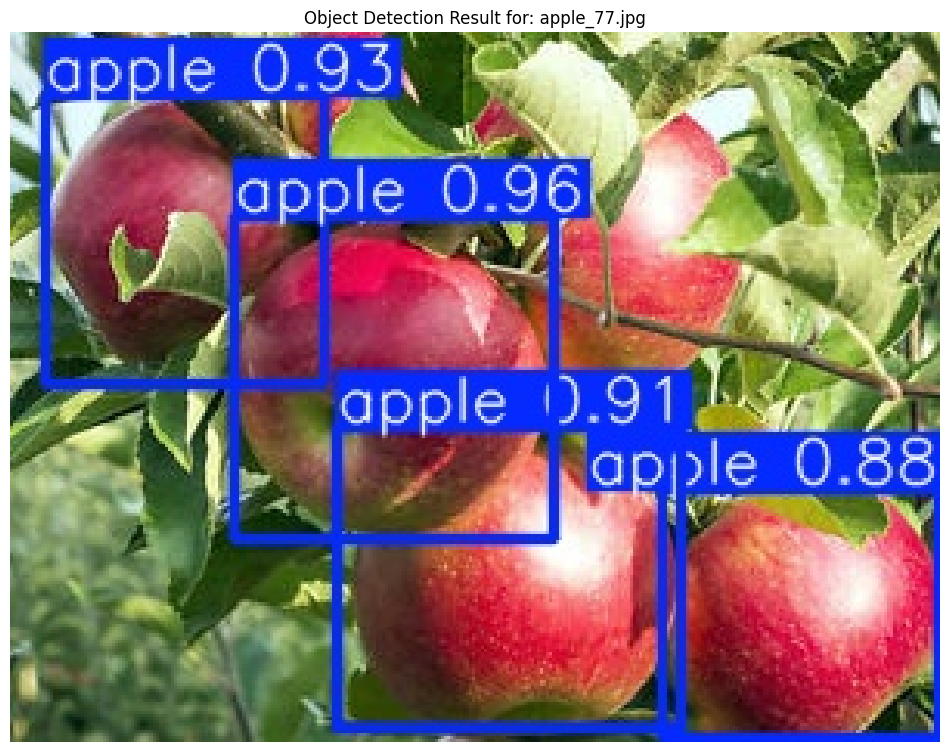

Detection result saved to: runs/detect/predict2/apple_77.jpg

--- Details of Detections ---

Image: apple_77.jpg
Detected 4 objects:
- Class: apple (ID: 0), Confidence: 0.96, BBox: [72.15634155273438, 59.458892822265625, 175.3673858642578, 163.9849090576172]
- Class: apple (ID: 0), Confidence: 0.93, BBox: [11.096590995788574, 20.274717330932617, 101.0884017944336, 113.59276580810547]
- Class: apple (ID: 0), Confidence: 0.91, BBox: [105.92573547363281, 127.94098663330078, 216.92503356933594, 224.82025146484375]
- Class: apple (ID: 0), Confidence: 0.88, BBox: [210.25328063964844, 147.39483642578125, 299.41754150390625, 227.2314910888672]


In [72]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np # เพิ่ม import numpy สำหรับ cv2.cvtColor หากยังไม่มี

# โหลดโมเดลที่ train มาแล้ว
# !!! โปรดตรวจสอบ Path ให้ถูกต้องกับชื่อ run ของคุณ (เช่น fruit_detection_yolov8n2) !!!
trained_model_path = "/content/runs/detect/fruit_detection_yolov8n2/weights/best.pt"

# เลือกภาพตัวอย่างสำหรับ Test
# คุณสามารถเปลี่ยนเป็นภาพอื่นๆ ในโฟลเดอร์ /content/fruit_dataset/test_zip/test/ ได้
test_image_file = "/content/fruit_dataset/test_zip/test/apple_77.jpg"

if not os.path.exists(trained_model_path):
    print(f"Error: Trained model not found at {trained_model_path}. Please check the path and the run name.")
elif not os.path.exists(test_image_file):
    print(f"Error: Test image not found at {test_image_file}. Please check the path.")
else:
    model = YOLO(trained_model_path)
    print(f"Successfully loaded trained model from {trained_model_path}")

    # ทำการตรวจจับวัตถุบนภาพ
    # save=True จะบอกให้ YOLOv8 บันทึกภาพที่มี bounding box ลงในโฟลเดอร์ results
    # show_labels=True, show_conf=True จะทำให้ label และ confidence score แสดงบนภาพ
    results = model.predict(source=test_image_file, conf=0.5, iou=0.7, save=True, show_labels=True, show_conf=True)

    # --- ส่วนการแสดงผลภาพ ---
    # YOLOv8 จะบันทึกภาพผลลัพธ์ไว้ในโฟลเดอร์ย่อยของ runs/detect/predictX (เช่น predict, predict2)
    # results[0].save_dir คือ path ของโฟลเดอร์ที่บันทึกผลลัพธ์ของ inference ครั้งล่าสุด
    predicted_image_path = os.path.join(results[0].save_dir, os.path.basename(test_image_file))

    if os.path.exists(predicted_image_path):
        img_result = cv2.imread(predicted_image_path) # อ่านภาพด้วย OpenCV
        if img_result is not None:
            plt.figure(figsize=(12, 10)) # กำหนดขนาดของกราฟที่จะแสดงภาพ
            # OpenCV อ่านภาพเป็น BGR (Blue, Green, Red) แต่ Matplotlib แสดงเป็น RGB
            # เราจึงต้องแปลงจาก BGR เป็น RGB ก่อนแสดงผล
            plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
            plt.title(f"Object Detection Result for: {os.path.basename(test_image_file)}")
            plt.axis('off') # ปิดแกน x และ y
            plt.show() # แสดงภาพ
            print(f"Detection result saved to: {predicted_image_path}")
        else:
            print(f"Error: Could not read predicted image from {predicted_image_path}")
    else:
        print(f"Error: Predicted image not found at {predicted_image_path}. Please ensure save=True was used and check the path.")

    # --- ส่วนแสดงรายละเอียดของ detections (Text Output) ---
    print("\n--- Details of Detections ---")
    for r in results: # 'results' object จะมีข้อมูลของแต่ละภาพที่ถูก predict
        print(f"\nImage: {os.path.basename(r.path)}")
        print(f"Detected {len(r.boxes)} objects:")
        for box in r.boxes: # วนลูปผ่านแต่ละ bounding box ที่ตรวจจับได้
            cls = int(box.cls[0]) # Class ID (เช่น 0 สำหรับ apple, 1 สำหรับ banana)
            conf = round(float(box.conf[0]), 2) # Confidence score (ความมั่นใจ)
            xyxy = box.xyxy[0].tolist() # Bounding box coordinates in [xmin, ymin, xmax, ymax] format
            print(f"- Class: {model.names[cls]} (ID: {cls}), Confidence: {conf}, BBox: {xyxy}")

Successfully loaded trained model from /content/runs/detect/fruit_detection_yolov8n2/weights/best.pt
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1749.7±569.5 MB/s, size: 121.1 KB)


val: Scanning /content/yolo_dataset/labels/test.cache... 110 images, 0 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<?, ?it/s]

val: /content/yolo_dataset/images/test/apple_62.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


                   all        110        226      0.936      0.896      0.946       0.78
                 apple         45         78      0.885      0.949      0.974      0.843
                banana         40         70      0.936      0.835      0.911      0.686
                orange         41         78      0.986      0.903      0.952      0.811
Speed: 6.4ms preprocess, 11.9ms inference, 0.0ms loss, 3.0ms postprocess per image
Saving runs/detect/fruit_detection_evaluation2/predictions.json...
Results saved to runs/detect/fruit_detection_evaluation2

--- Overall Evaluation Results ---
mAP50: 0.9456
mAP50-95: 0.7801
Mean Precision: 0.9356
Mean Recall: 0.8955

--- Per-Class Metrics ---
Class: apple (ID: 0)
  Precision: 0.8849
  Recall: 0.9487
  mAP50: 0.9741
  mAP50-95: 0.8429
Class: banana (ID: 1)
  Precision: 0.9359
  Recall: 0.8345
  mAP50: 0.9113
  mAP50-95: 0.6863
Class: orange (ID: 2)
  Precision: 0.9860
  Recall: 0.9033
  mAP50: 0.9515
  mAP50-95: 0.8110

Evaluation results

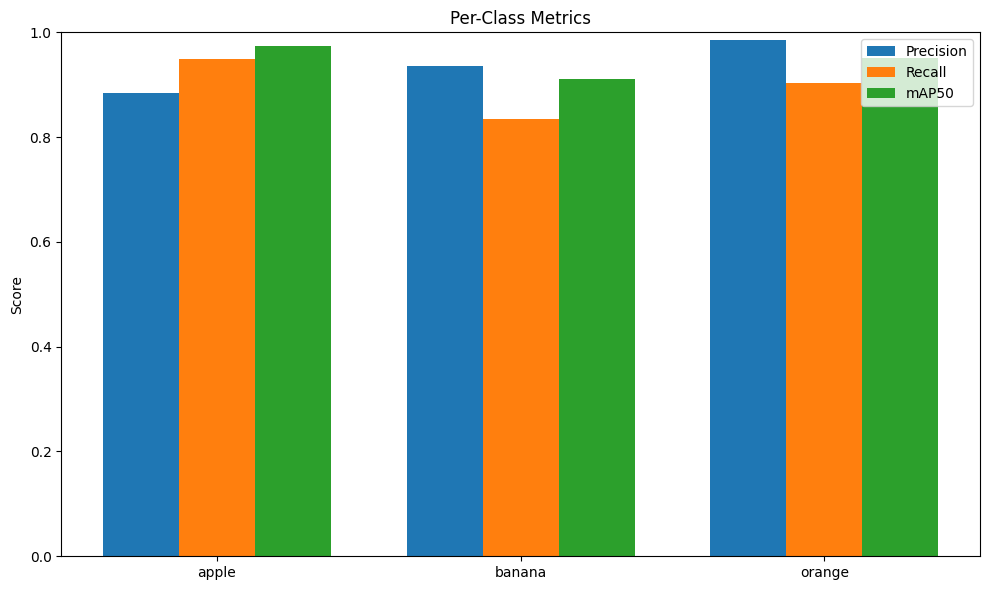

In [73]:
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
import numpy as np

# โหลดโมเดลที่ train มาแล้ว
# !!! โปรดตรวจสอบ Path ให้ถูกต้องกับชื่อ run ของคุณ !!!
# จากผลลัพธ์การ train ล่าสุดของคุณคือ 'fruit_detection_yolov8n2'
trained_model_path = "/content/runs/detect/fruit_detection_yolov8n2/weights/best.pt"

# ตรวจสอบว่าโมเดลมีอยู่จริง
if not os.path.exists(trained_model_path):
    print(f"Error: Trained model not found at {trained_model_path}. Please check the path and the run name.")
else:
    model = YOLO(trained_model_path)
    print(f"Successfully loaded trained model from {trained_model_path}")

    # กำหนด Path ไปยังไฟล์ YAML ของ dataset
    yaml_data_path = "/content/yolo_dataset/data.yaml"

    # ทำการ Evaluation โมเดล
    metrics = model.val(
        data=yaml_data_path,
        imgsz=640, # ควรใช้ขนาดภาพเดียวกับที่ใช้ Train
        batch=16,  # ควรใช้ batch size เดียวกับที่ใช้ Train
        conf=0.25, # Confidence threshold
        iou=0.7,   # IoU threshold for NMS
        save_json=True, # บันทึกผลลัพธ์เป็น COCO JSON
        name='fruit_detection_evaluation', # ชื่อโฟลเดอร์สำหรับผลลัพธ์ evaluation
        device=0 # ใช้ GPU
    )

    # แสดงผลลัพธ์ Metric หลักๆ
    print("\n--- Overall Evaluation Results ---")
    print(f"mAP50: {metrics.box.map50:.4f}")       # mAP@0.5 IoU
    print(f"mAP50-95: {metrics.box.map:.4f}")      # mAP@0.5-0.95 IoU
    print(f"Mean Precision: {metrics.box.mp:.4f}") # Mean Precision across all classes
    print(f"Mean Recall: {metrics.box.mr:.4f}")    # Mean Recall across all classes

    # แสดงรายละเอียด Metric ของแต่ละคลาส
    print("\n--- Per-Class Metrics ---")
    class_names_dict = model.names # ดึงชื่อคลาสจากโมเดลในรูปแบบ dict (id: name)

    # ดึงค่า p, r, ap50, ap ของแต่ละคลาส
    # *** แก้ไขตรงนี้: ลบวงเล็บ () ออก เนื่องจากเป็น numpy array ไม่ใช่เมธอด ***
    precisions_per_class = metrics.box.p
    recalls_per_class = metrics.box.r
    ap50_per_class = metrics.box.ap50 # เข้าถึงโดยตรง
    ap_per_class = metrics.box.ap     # เข้าถึงโดยตรง

    # เตรียมข้อมูลสำหรับกราฟ
    class_labels = []
    class_precision_values = []
    class_recall_values = []
    class_map50_values = []

    for i in sorted(class_names_dict.keys()): # วนลูปตาม Class ID ที่เรียงลำดับ
        name = class_names_dict[i]

        # ตรวจสอบว่า index ไม่เกินขอบเขตของ array
        precision = precisions_per_class[i] if i < len(precisions_per_class) else np.nan
        recall = recalls_per_class[i] if i < len(recalls_per_class) else np.nan
        map50 = ap50_per_class[i] if i < len(ap50_per_class) else np.nan
        map = ap_per_class[i] if i < len(ap_per_class) else np.nan

        print(f"Class: {name} (ID: {i})")
        print(f"  Precision: {precision:.4f}" if not np.isnan(precision) else "  Precision: N/A")
        print(f"  Recall: {recall:.4f}" if not np.isnan(recall) else "  Recall: N/A")
        print(f"  mAP50: {map50:.4f}" if not np.isnan(map50) else "  mAP50: N/A")
        print(f"  mAP50-95: {map:.4f}" if not np.isnan(map) else "  mAP50-95: N/A")

        class_labels.append(name)
        class_precision_values.append(precision)
        class_recall_values.append(recall)
        class_map50_values.append(map50)

    print(f"\nEvaluation results are saved in {metrics.save_dir}")

    # --- สร้างกราฟแสดงผลลัพธ์ ---
    x = np.arange(len(class_labels)) # the label locations
    width = 0.25 # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # ลบค่า NaN ออกก่อน plot เพื่อไม่ให้เกิด error
    # ต้องกรองข้อมูลที่ใช้ plot แยกกันสำหรับแต่ละแท่งกราฟ
    valid_indices_p = ~np.isnan(class_precision_values)
    valid_indices_r = ~np.isnan(class_recall_values)
    valid_indices_m = ~np.isnan(class_map50_values)

    rects1 = ax.bar(x[valid_indices_p] - width, np.array(class_precision_values)[valid_indices_p], width, label='Precision')
    rects2 = ax.bar(x[valid_indices_r] , np.array(class_recall_values)[valid_indices_r], width, label='Recall')
    rects3 = ax.bar(x[valid_indices_m] + width, np.array(class_map50_values)[valid_indices_m], width, label='mAP50')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title('Per-Class Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels)
    ax.legend()
    ax.set_ylim(0, 1.0) # Scores are between 0 and 1

    fig.tight_layout()
    plt.show()


--- Confusion Matrix ---


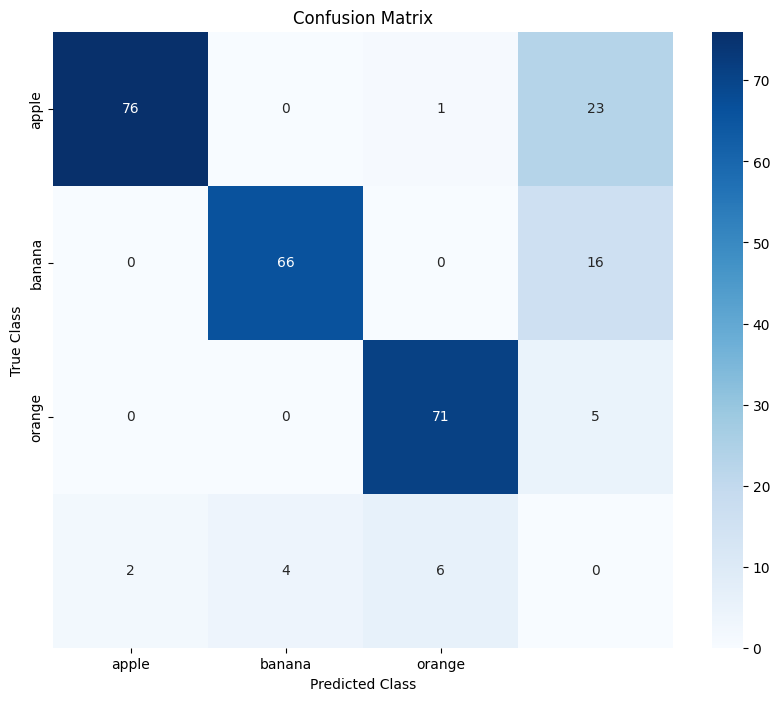

In [74]:
# prompt: confusion matrix

import matplotlib.pyplot as plt
# Assuming 'metrics' object from model.val() is available
# and contains the confusion matrix data.
# The confusion matrix is typically stored as a numpy array within the metrics object.
# The exact attribute name might vary slightly depending on the YOLOv8 version and configuration,
# but it's commonly accessed via metrics.confusion_matrix or similar.

# Let's assume the confusion matrix is accessible via metrics.confusion_matrix.matrix
# If not, you might need to inspect the 'metrics' object structure.

# Example of how to access the confusion matrix (adjust attribute name if needed)
try:
    confusion_matrix = metrics.confusion_matrix.matrix
    class_names_list = list(model.names.values()) # Get class names as a list

    print("\n--- Confusion Matrix ---")
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    # Use seaborn for a nice heatmap
    import seaborn as sns
    sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=class_names_list, yticklabels=class_names_list)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.show()

except AttributeError:
    print("\nCould not find confusion matrix in the evaluation results.")
    print("Please check the structure of the 'metrics' object after running model.val().")
    print("The confusion matrix might be stored under a different attribute name.")
except Exception as e:
    print(f"\nAn error occurred while trying to plot the confusion matrix: {e}")



In [75]:
# Inspect the structure of the metrics object
# This will help us find where the per-class metrics and confusion matrix are stored.

if 'metrics' in locals() and metrics is not None:
    print("Metrics object attributes:")
    print(dir(metrics))

    if hasattr(metrics, 'box'):
        print("\nmetrics.box attributes:")
        print(dir(metrics.box))

        # Attempt to print some potentially relevant attributes
        print("\nPotential metrics.box attributes:")
        for attr in ['p', 'r', 'ap50', 'ap', 'confusion_matrix']:
            if hasattr(metrics.box, attr):
                print(f"metrics.box.{attr}:")
                try:
                    # Print type and value (or shape if it's an array)
                    value = getattr(metrics.box, attr)
                    if isinstance(value, np.ndarray):
                        print(f"  Type: {type(value)}, Shape: {value.shape}")
                        # Print value for small arrays
                        if value.size < 20:
                             print(f"  Value: {value}")
                    else:
                         print(f"  Type: {type(value)}, Value: {value}")
                except Exception as e:
                    print(f"  Could not access: {e}")
            else:
                print(f"metrics.box has no attribute '{attr}'")

    if hasattr(metrics, 'confusion_matrix'):
         print("\nmetrics.confusion_matrix attributes:")
         print(dir(metrics.confusion_matrix))
         if hasattr(metrics.confusion_matrix, 'matrix'):
             print("\nmetrics.confusion_matrix.matrix:")
             try:
                 value = metrics.confusion_matrix.matrix
                 if isinstance(value, np.ndarray):
                     print(f"  Type: {type(value)}, Shape: {value.shape}")
                     # Print value for small matrices
                     if value.size < 30: # Adjust threshold as needed
                         print(f"  Value:\n{value}")
                 else:
                      print(f"  Type: {type(value)}, Value: {value}")
             except Exception as e:
                 print(f"  Could not access: {e}")
         else:
             print("metrics.confusion_matrix has no attribute 'matrix'")


else:
    print("Metrics object not found. Please run the model.val() step first.")

Metrics object attributes:
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'ap_class_index', 'box', 'class_result', 'clear_stats', 'confusion_matrix', 'curves', 'curves_results', 'fitness', 'keys', 'maps', 'mean_results', 'names', 'nt_per_class', 'nt_per_image', 'process', 'results_dict', 'save_dir', 'speed', 'stats', 'summary', 'task', 'to_csv', 'to_df', 'to_html', 'to_json', 'to_sql', 'to_xml', 'tojson', 'update_stats']

metrics.box attributes:
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__'

Successfully loaded trained model from /content/runs/detect/fruit_detection_yolov8n2/weights/best.pt

--- Upload your image for object detection ---
Click 'Choose Files' to upload an image.


Saving images.jpg to images.jpg
User uploaded file "images.jpg" (6863 bytes)
Processing uploaded image: images.jpg

0: 448x640 4 bananas, 43.6ms
Speed: 2.4ms preprocess, 43.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


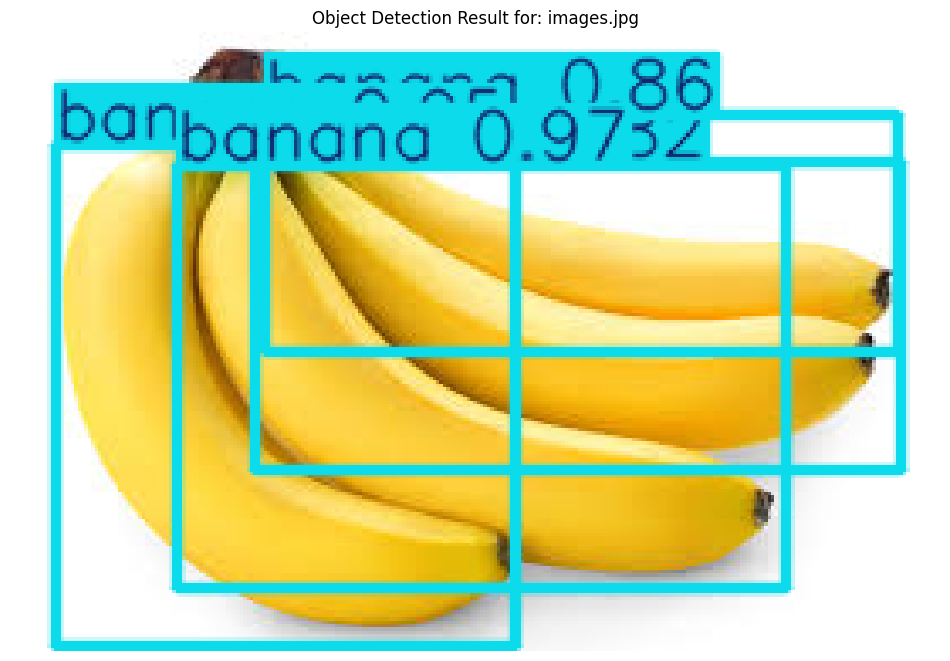


--- Details of Detections ---
Detected 4 objects:
- Class: banana (ID: 1), Confidence: 0.97, BBox: [49.92939758300781, 39.4633903503418, 229.72036743164062, 164.04933166503906]
- Class: banana (ID: 1), Confidence: 0.95, BBox: [13.739221572875977, 33.44118118286133, 149.30258178710938, 181.10238647460938]
- Class: banana (ID: 1), Confidence: 0.86, BBox: [75.56242370605469, 24.385774612426758, 262.7140808105469, 94.98771667480469]
- Class: banana (ID: 1), Confidence: 0.82, BBox: [72.23531341552734, 38.31910705566406, 263.9957275390625, 129.50039672851562]


In [82]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files # สำหรับอัปโหลดไฟล์ใน Colab
import io # สำหรับอ่านไฟล์ที่อัปโหลด

# โหลดโมเดลที่ train มาแล้ว
# !!! โปรดตรวจสอบ Path ให้ถูกต้องกับชื่อ run ของคุณ !!!
# จากผลลัพธ์การ train ล่าสุดของคุณคือ 'fruit_detection_yolov8n2'
trained_model_path = "/content/runs/detect/fruit_detection_yolov8n2/weights/best.pt"

# ตรวจสอบว่าโมเดลมีอยู่จริง
if not os.path.exists(trained_model_path):
    print(f"Error: Trained model not found at {trained_model_path}. Please check the path and the run name.")
else:
    model = YOLO(trained_model_path)
    print(f"Successfully loaded trained model from {trained_model_path}")

    print("\n--- Upload your image for object detection ---")
    print("Click 'Choose Files' to upload an image.")

    uploaded = files.upload() # นี่คือส่วนที่อนุญาตให้อัปโหลดไฟล์

    if len(uploaded) == 0:
        print("No file uploaded. Please upload an image to proceed.")
    else:
        for fn in uploaded.keys():
            print(f'User uploaded file "{fn}" ({len(uploaded[fn])} bytes)')

            # อ่านภาพที่อัปโหลด
            img_bytes = uploaded[fn]
            img_np = np.frombuffer(img_bytes, np.uint8)
            img = cv2.imdecode(img_np, cv2.IMREAD_COLOR) # อ่านภาพเป็น BGR format โดย OpenCV

            if img is None:
                print(f"Error: Could not decode image '{fn}'. Please ensure it's a valid image file (e.g., .jpg, .png).")
                continue

            print(f"Processing uploaded image: {fn}")

            # ทำการตรวจจับวัตถุบนภาพที่อัปโหลด
            # conf: ค่าความเชื่อมั่นขั้นต่ำ (confidence threshold)
            # iou: Intersection Over Union threshold สำหรับ NMS
            # save=True: บันทึกภาพที่มี bounding box (ไม่จำเป็นต้อง save ถ้าแค่ต้องการแสดง)
            # show_labels=True, show_conf=True: แสดง label และ confidence บนภาพ
            results = model.predict(source=img, conf=0.5, iou=0.7, save=False, show_labels=True, show_conf=True)

            # แสดงผลลัพธ์
            if results and len(results) > 0:
                r = results[0] # ผลลัพธ์สำหรับภาพแรกที่ถูกประมวลผล

                # แปลงภาพผลลัพธ์จาก BGR (OpenCV) เป็น RGB (Matplotlib) เพื่อแสดงผล
                img_detected_rgb = cv2.cvtColor(r.plot(), cv2.COLOR_BGR2RGB)

                plt.figure(figsize=(12, 10))
                plt.imshow(img_detected_rgb)
                plt.title(f"Object Detection Result for: {fn}")
                plt.axis('off')
                plt.show()

                # แสดงรายละเอียดการตรวจจับเป็นข้อความ
                print("\n--- Details of Detections ---")
                print(f"Detected {len(r.boxes)} objects:")
                if len(r.boxes) > 0:
                    for box in r.boxes:
                        cls = int(box.cls[0])
                        conf = round(float(box.conf[0]), 2)
                        xyxy = box.xyxy[0].tolist() # [xmin, ymin, xmax, ymax]
                        print(f"- Class: {model.names[cls]} (ID: {cls}), Confidence: {conf}, BBox: {xyxy}")
                else:
                    print("No objects detected in this image.")
            else:
                print("No detection results found for this image.")